In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant 


data = pd.read_csv('train_1.csv')
data['px'] = data['px_height'] * data['px_width']
data_px = data.drop('px_height',axis=1)
data_px = data_px.drop('px_width',axis=1)
data_px['sc'] = data_px['sc_h']*data_px['sc_w']
data_px = data_px.drop('sc_h',axis=1)
data_px = data_px.drop('sc_w',axis=1)
data_px = data_px.drop('three_g',axis=1) #незначимый столбец

In [2]:
data_cor = data_px.drop('price_range', axis=1)  
vif = [variance_inflation_factor(data_cor.values, data_cor.columns.get_loc(i)) for i in data_cor.columns]

ds=pd.Series(
    vif,   
    index=data_cor.columns
) 
ds # мультиколлинеарность есть, для этого можно удалить столбец mobile_wt или применить PCA

battery_power     7.855053
blue              1.977358
clock_speed       4.215547
dual_sim          1.995854
fc                3.410426
four_g            2.050176
int_memory        3.884432
m_dep             3.871176
mobile_wt        11.865841
n_cores           4.524659
pc                6.161952
ram               4.611167
talk_time         4.777305
touch_screen      1.982163
wifi              2.005841
px                2.169693
sc                2.073933
dtype: float64

In [3]:
pca = PCA(n_components=3).fit(data_px)
pca_3d = pca.transform(data_px)
data_y = data_px.price_range
x_train, x_test, y_train, y_test = train_test_split(pca_3d, data_y, test_size=0.2)

In [6]:
# CatBoost

model = CatBoostClassifier(
    iterations=368,
    random_seed=0,
    learning_rate=0.15
)

model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    verbose=False,
    plot=True
)

model.score(x_test, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.91

In [8]:
# RandomForest
cl = RandomForestClassifier()
param_dist = {'n_estimators': [110,120,130],
              'max_depth': [20,23,25],
              'min_samples_split': [8,15,20],
              'min_samples_leaf': [2,3,4],
             }
gs = GridSearchCV(cl, param_dist, cv=5)
gs.fit(x_train, y_train)
c = gs.best_params_

cl = RandomForestClassifier(
    max_depth=c['max_depth'],
    n_estimators= c['n_estimators'] ,
    min_samples_leaf=c['min_samples_leaf'],
    min_samples_split=c['min_samples_split']
)

cl.fit(x_train,y_train)
n = cl.predict(x_test)
l = np.array(y_test)
f1_score(l,n,average='micro')

0.89

In [9]:
from xgboost import XGBClassifier
model1 = XGBClassifier(max_depth=15, n_estimators=120)
model1.fit(x_train, y_train)
model1.score(x_test, y_test)


0.895

0.8875


<AxesSubplot:>

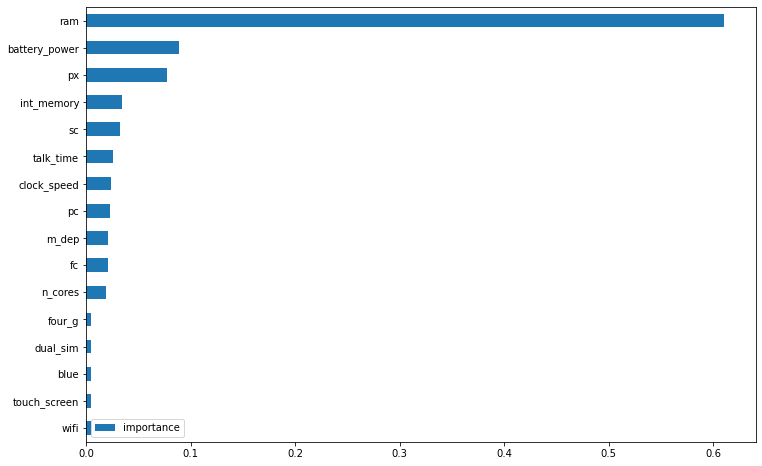

In [10]:
data_px = data_px.drop('mobile_wt',axis=1)# то же самое, только с удалением mobile_wt

data_y = data_px.price_range
data_x = data_px.drop('price_range',axis=1)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)
cl = RandomForestClassifier(max_depth=23, n_estimators=110, min_samples_leaf=2,
                            min_samples_split=8)
cl.fit(x_train, y_train)
n = cl.predict(x_test)
l = np.array(y_test)
print(f1_score(l, n, average='micro'))

imp = pd.DataFrame(cl.feature_importances_, index=x_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))